In [1]:
import pandas as pd
from neuralprophet import NeuralProphet

/Users/dylan/src/coin-prophet/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Please download the following and put it in the main project dir
# https://www.kaggle.com/mczielinski/bitcoin-historical-data
input_df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
input_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df = input_df.rename(columns={"Timestamp": "ds", "Volume_(BTC)": "y"})
df = df[["ds", "y"]]
df.dropna(inplace=True)

# Unix time for the year 2021
df = df.loc[(df["ds"] > 1577836800) & (1609455599 > df["ds"])]

# Localize the unix time to correct timezone and format value
ds_datetime = pd.to_datetime(df.loc[:, "ds"], unit="s")
df.loc[:, "ds"] = ds_datetime.dt.strftime("%Y-%m-%d %H:%M:%S")

df

,ds,y
4202177,2020-01-01 00:01:00,3.776924
4202178,2020-01-01 00:02:00,0.029278
4202179,2020-01-01 00:03:00,0.065819
4202180,2020-01-01 00:04:00,0.971387
4202181,2020-01-01 00:05:00,0.886932
...,...,...
4729151,2020-12-31 22:55:00,0.427177
4729152,2020-12-31 22:56:00,2.384748
4729153,2020-12-31 22:57:00,0.573644
4729154,2020-12-31 22:58:00,3.784999


In [4]:
# Need to make "ds" the index so we can work with pd.Grouper
df_hourly = df
df_hourly.index = pd.to_datetime(df['ds'])
df_hourly = df.drop('ds', axis = 1)

# Groupby every minute to every 1 hour
df_hourly = df_hourly.groupby(pd.Grouper(freq='60min')).sum()
df_hourly["ds"] = df_hourly.index

df_hourly.reset_index(drop=True, inplace=True)
df_hourly

,y,ds
0,49.675785,2020-01-01 00:00:00
1,96.119780,2020-01-01 01:00:00
2,62.107763,2020-01-01 02:00:00
3,50.115685,2020-01-01 03:00:00
4,25.662523,2020-01-01 04:00:00
...,...,...
8778,452.901605,2020-12-31 18:00:00
8779,365.064315,2020-12-31 19:00:00
8780,520.772208,2020-12-31 20:00:00
8781,394.441884,2020-12-31 21:00:00


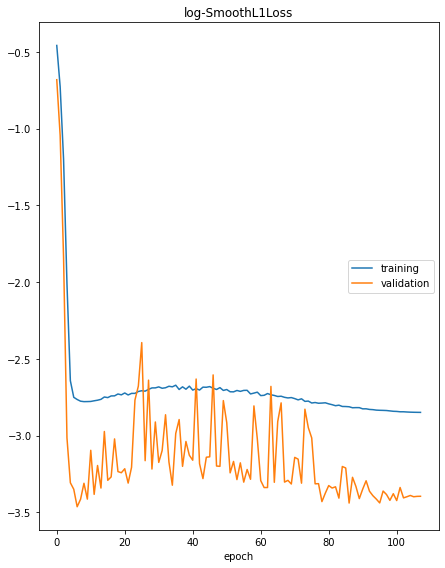

Epoch[108/108]: 100%|██████████| 108/108 [00:13<00:00,  7.81it/s, SmoothL1Loss=0.0579, MAE=230, RMSE=383, RegLoss=0.0443, MAE_val=176, RMSE_val=291, SmoothL1Loss_val=0.0335]


In [5]:
m = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.03
)
df_train, df_test = m.split_df(df_hourly, freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [6]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
107,0.057936,229.796231,383.369902,0.044259,0.033544,176.12912,290.823853


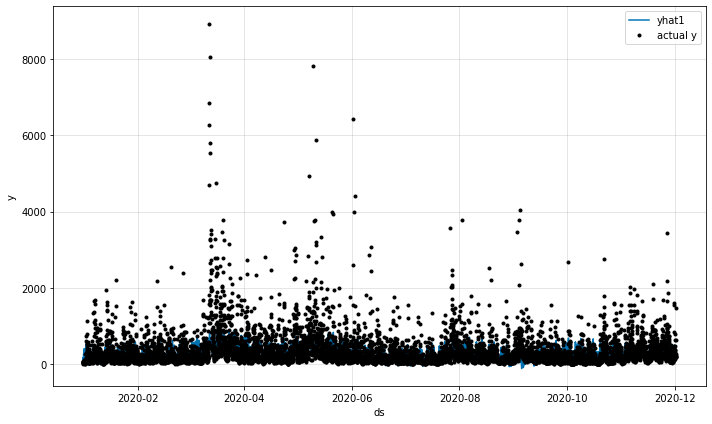

In [7]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

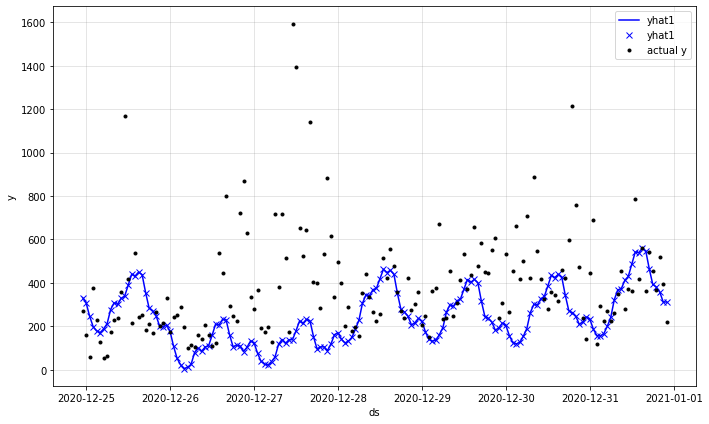

In [8]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

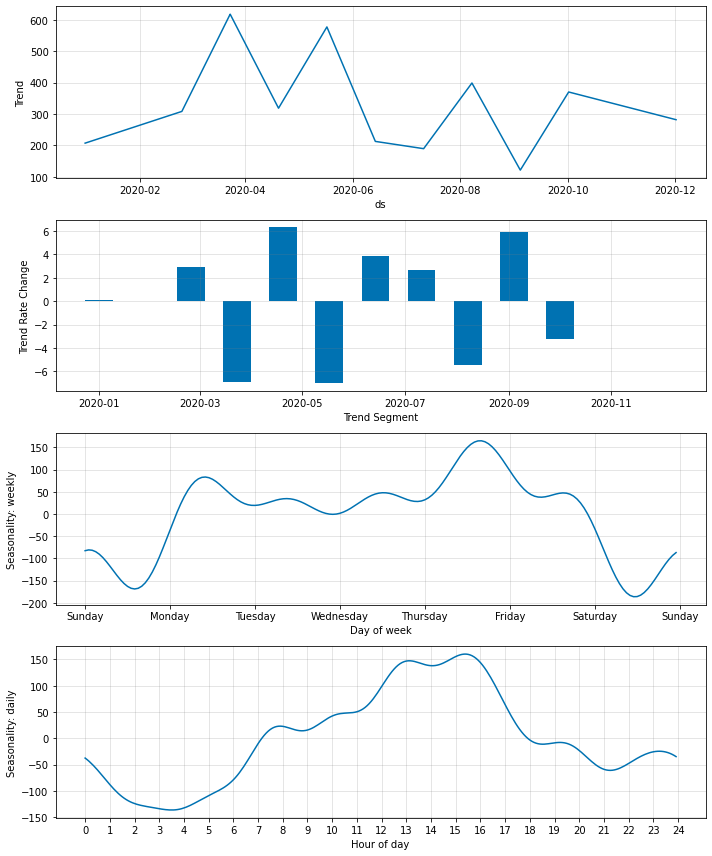

In [9]:
fig_param = m.plot_parameters()

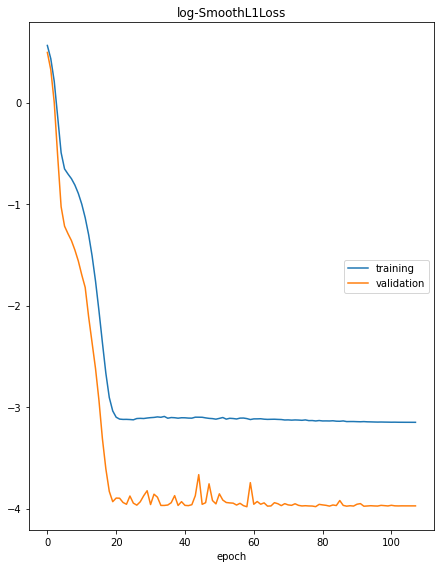

Epoch[108/108]: 100%|██████████| 108/108 [00:09<00:00, 11.26it/s, SmoothL1Loss=0.0429, MAE=186, RMSE=319, RegLoss=0.000389, MAE_val=128, RMSE_val=217, SmoothL1Loss_val=0.0188]


In [10]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_sparsity=0.95,
    learning_rate = 0.003,
)
df_train, df_test = m.split_df(df_hourly, freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [11]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
107,0.042862,186.134604,319.467751,0.000389,0.018815,128.076492,217.324295


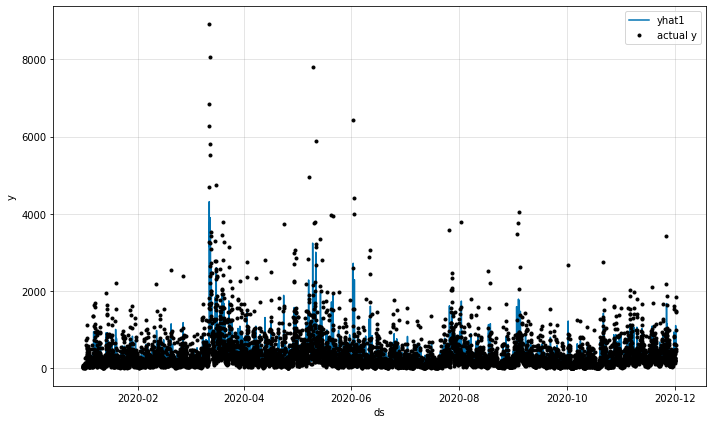

In [12]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

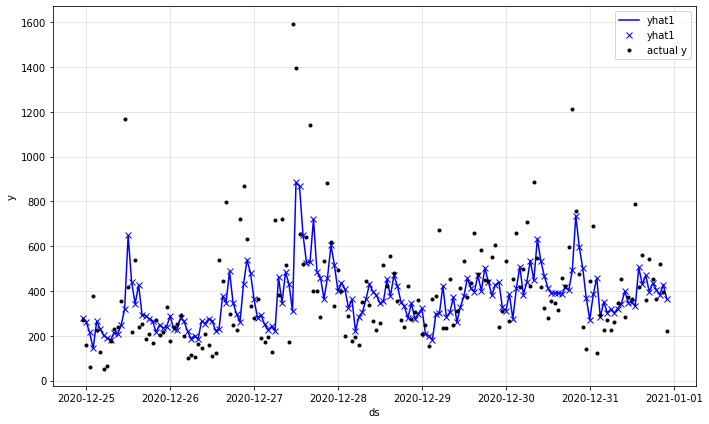

In [13]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

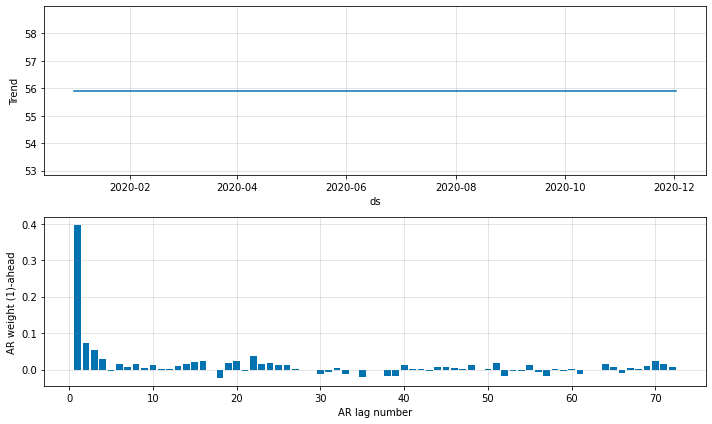

In [14]:
fig_param = m.plot_parameters()
